# Deep Reinforcement Learning for the CartPole Environment


### Install All Necessaery Libraries/Packages

In [331]:
!apt-get update
!apt-get install -y xvfb python3-opengl ffmpeg
!pip install gym pyvirtualdisplay

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is alre

In [332]:
# Install packages
import gym
import copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import time
from pyvirtualdisplay import Display

## Environment

Source: [https://gym.openai.com/envs/CartPole-v1/](Open AI Gym).

In [333]:
env = gym.envs.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Plotting Function

In [334]:
def plot_res(values, title=''):
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)

    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')

    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

## Deep Q Learning

In [335]:
class DQN(nn.Module):
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            super(DQN, self).__init__()
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def forward(self, state):
        # Define the forward pass of the model.
        return self.model(state)

    def update(self, state, y):
        # Update the weights of the network given a training sample.
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        # Compute Q values for all actions using the DQL.
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [336]:
def q_learning(env, model, episodes, gamma=0.9,
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20,
               title = 'DQL', double=False,
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0

    avg_cart_positions_per_episode = []
    avg_cart_velocities_per_episode = []
    avg_pole_angles_per_episode = []
    avg_pole_velocities_per_episode = []

    for episode in range(episodes):
        episode_i+=1
        cart_positions, cart_velocities, pole_angles, pole_velocities = [], [], [], []
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()

        # Reset state
        state = env.reset()
        done = False
        total = 0

        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()

            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)

            # Extract real-time data
            cart_pos, cart_vel, pole_angle, pole_vel = next_state
            cart_positions.append(cart_pos)
            cart_velocities.append(cart_vel)
            pole_angles.append(pole_angle)
            pole_velocities.append(pole_vel)

            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()

            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else:
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state

        # Calculate and store episode summaries
        avg_cart_positions_per_episode.append(np.mean(cart_positions))
        avg_cart_velocities_per_episode.append(np.mean(cart_velocities))
        avg_pole_angles_per_episode.append(np.mean(pole_angles))
        avg_pole_velocities_per_episode.append(np.mean(pole_velocities))

        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)

        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)

    # Dashboard-style plotting at the end of the function
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Performance Dashboard', fontsize=16)

    episodes_range = range(1, episodes + 1)

    # Plot for Average Cart Position
    axs[0, 0].plot(episodes_range, avg_cart_positions_per_episode, label='Cart Position', color='blue')
    axs[0, 0].set_title('Cart Position')
    axs[0, 0].set_xlabel('Episodes')
    axs[0, 0].set_ylabel('Position')
    axs[0, 0].legend()

    # Plot for Average Cart Velocity
    axs[0, 1].plot(episodes_range, avg_cart_velocities_per_episode, label='Cart Velocity', color='green')
    axs[0, 1].set_title('Cart Velocity')
    axs[0, 1].set_xlabel('Episodes')
    axs[0, 1].set_ylabel('Velocity')
    axs[0, 1].legend()

    # Plot for Average Pole Angle
    axs[-1, 0].plot(episodes_range, avg_pole_angles_per_episode, label='Pole Angle', color='red')
    axs[-1, 0].set_title('Pole Angle')
    axs[-1, 0].set_xlabel('Episodes')
    axs[-1, 0].set_ylabel('Angle')
    axs[-1, 0].legend()

    # Plot for Average Pole Velocity
    axs[-1, 1].plot(episodes_range, avg_pole_velocities_per_episode, label='Pole Velocity', color='purple')
    axs[-1, 1].set_title('Pole Velocity')
    axs[-1, 1].set_xlabel('Episodes')
    axs[-1, 1].set_ylabel('Velocity')
    axs[-1, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.show()


    torch.save(model.state_dict(), 'dqn_model.pth')

    return final

### Parameters

In [337]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 50
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

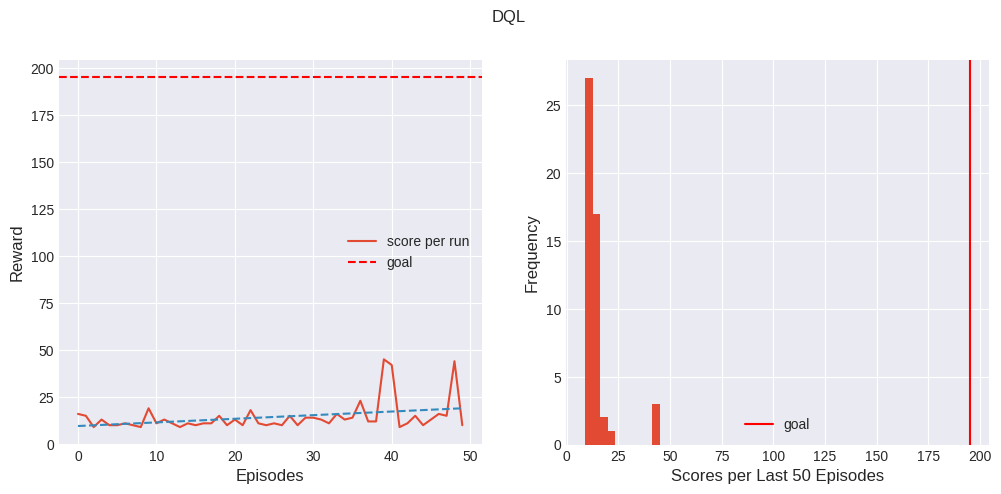

episode: 50, total reward: 10.0


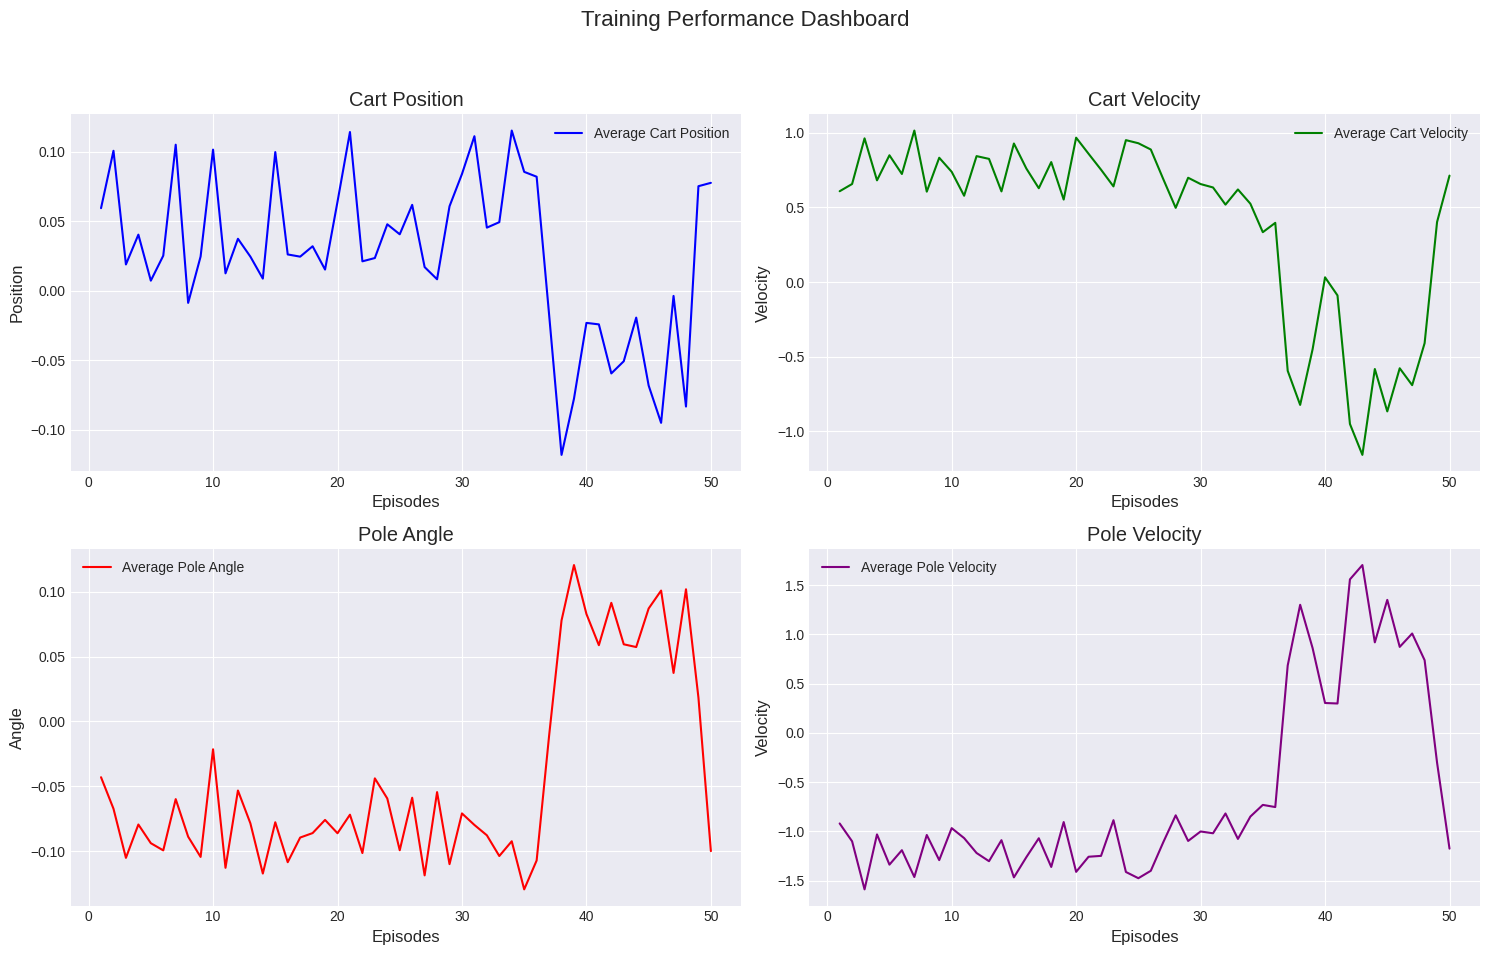

In [338]:
# Get DQN results
model = DQN(n_state, n_action, n_hidden, lr)
train_dqn = q_learning(env, model, episodes, gamma=.9, epsilon=0.3)

Attempting to Visualize the Cart Pole Task

In [339]:
model.load_state_dict(torch.load('dqn_model.pth'))
model.eval()  # Set the model to evaluation mode

DQN(
  (criterion): MSELoss()
  (model): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [340]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [341]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

import gym
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML, display  # Import display

def visualize_model(model, env_name, video_path='./video'):
    """
    Visualize the model performance in the environment.
    """
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_path, episode_trigger=lambda episode: True)
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()
        state, reward, done, _ = env.step(action)
    env.close()

    # Display the video
    mp4list = glob.glob(f'{video_path}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]  # Display the latest video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                </video>'''))
    else:
        print("Could not find video")


for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()

        state, reward, done, _ = env.step(action)
    if episode % 25 == 0:  # Every 25 episodes
        visualize_model(model, 'CartPole-v1')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Adding Replay Functionality to DQN

In [342]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]

            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)

            is_dones_indices = torch.where(is_dones_tensor==True)[0]

            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


            self.update(states.tolist(), all_q_values.tolist())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


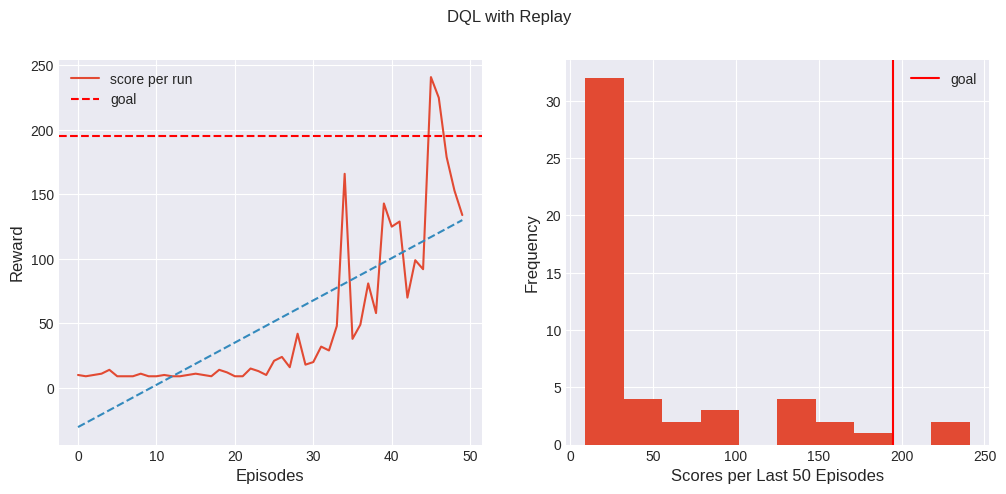

episode: 50, total reward: 134.0
Average replay time: 0.19011115074157714


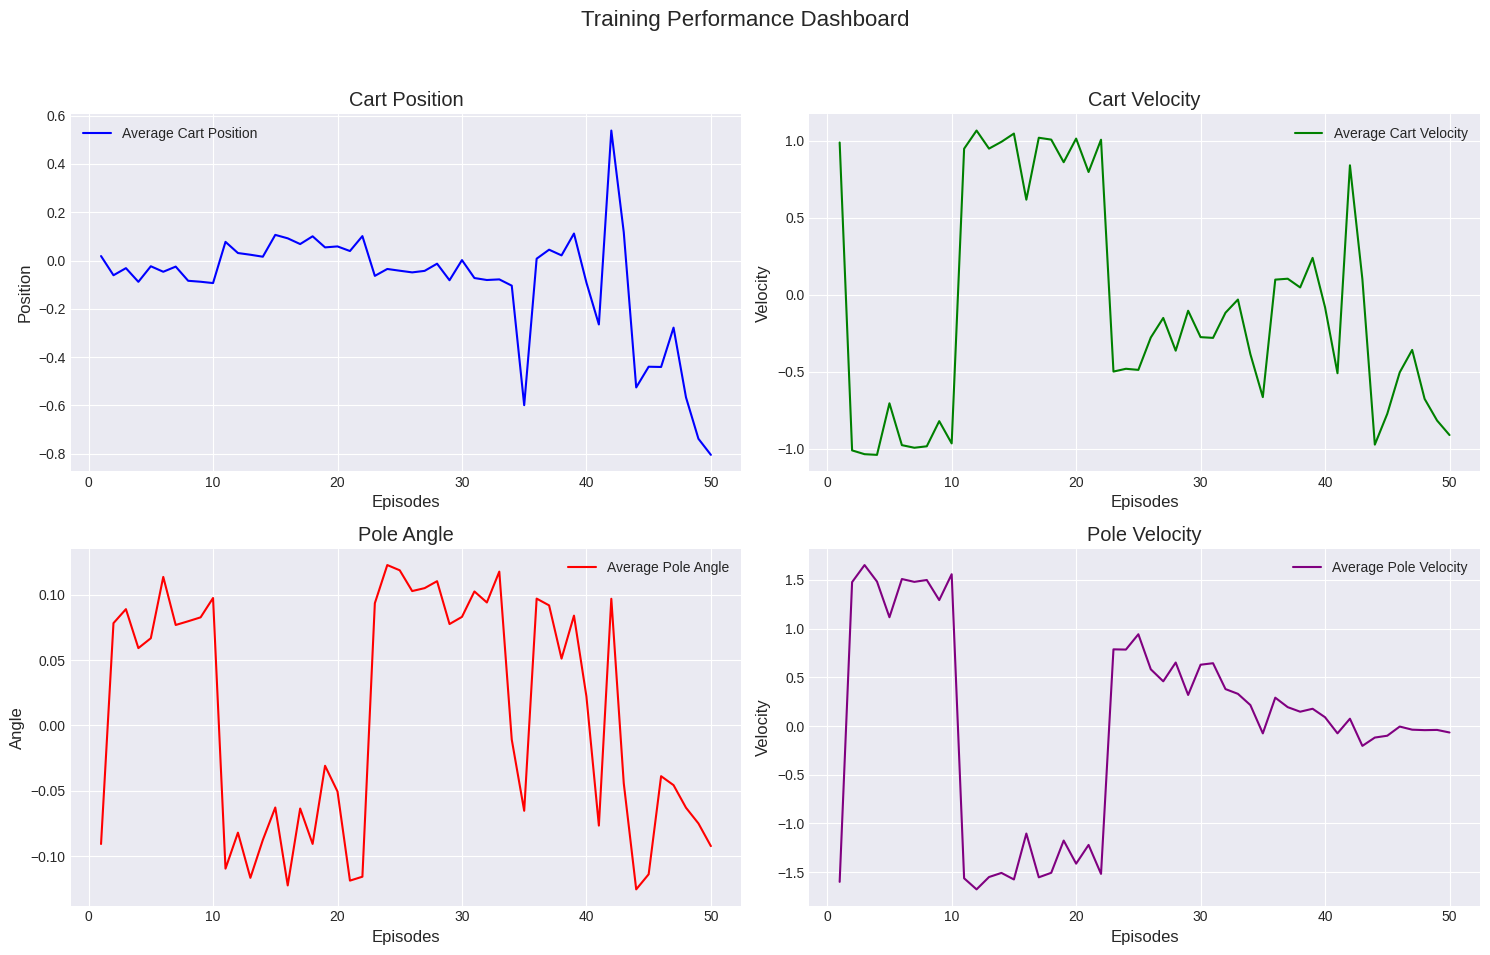

In [343]:
# Get replay results
model = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, model,
                    episodes, gamma=.9,
                    epsilon=0.2, replay=True,
                    title='DQL with Replay')

In [344]:
model.load_state_dict(torch.load('dqn_model.pth'))
model.eval()  # Set the model to evaluation mode

DQN_replay(
  (criterion): MSELoss()
  (model): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [345]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [346]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

import gym
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML, display  # Import display

def visualize_model(model, env_name, video_path='./video'):
    """
    Visualize the model performance in the environment.
    """
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_path, episode_trigger=lambda episode: True)
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()
        state, reward, done, _ = env.step(action)
    env.close()

    # Display the video
    mp4list = glob.glob(f'{video_path}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]  # Display the latest video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                </video>'''))
    else:
        print("Could not find video")


for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()

        state, reward, done, _ = env.step(action)
    if episode % 25 == 0:  # Every 25 episodes
        visualize_model(model, 'CartPole-v1')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Attempting One Layer No Activation Functions

In [347]:
class DQN(nn.Module):
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        super(DQN, self).__init__()
        self.criterion = torch.nn.MSELoss()
        # Single linear layer
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dim, action_dim)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def forward(self, state):
        # Define the forward pass of the model.
        return self.model(state)

    def update(self, state, y):
        # Update the weights of the network given a training sample.
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        # Compute Q values for all actions using the DQL.
        with torch.no_grad():
            return self.model(torch.Tensor(state))

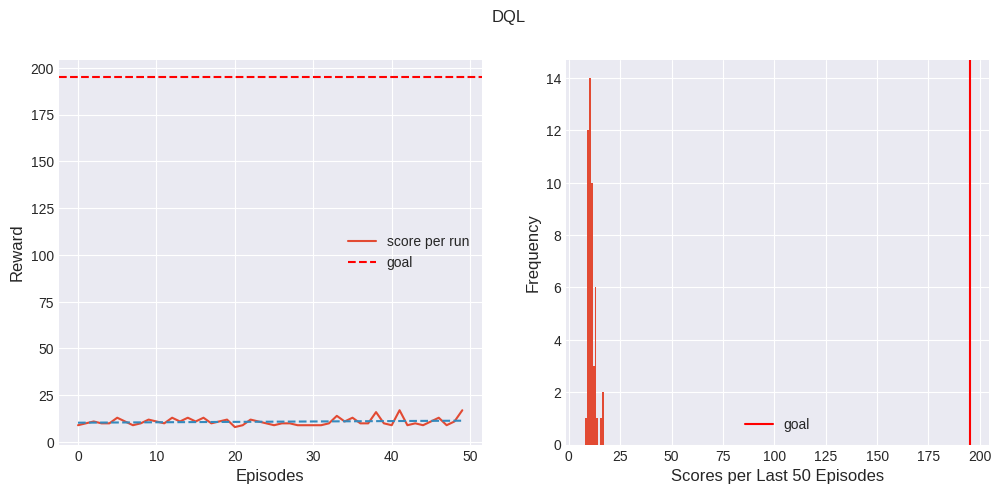

episode: 50, total reward: 17.0


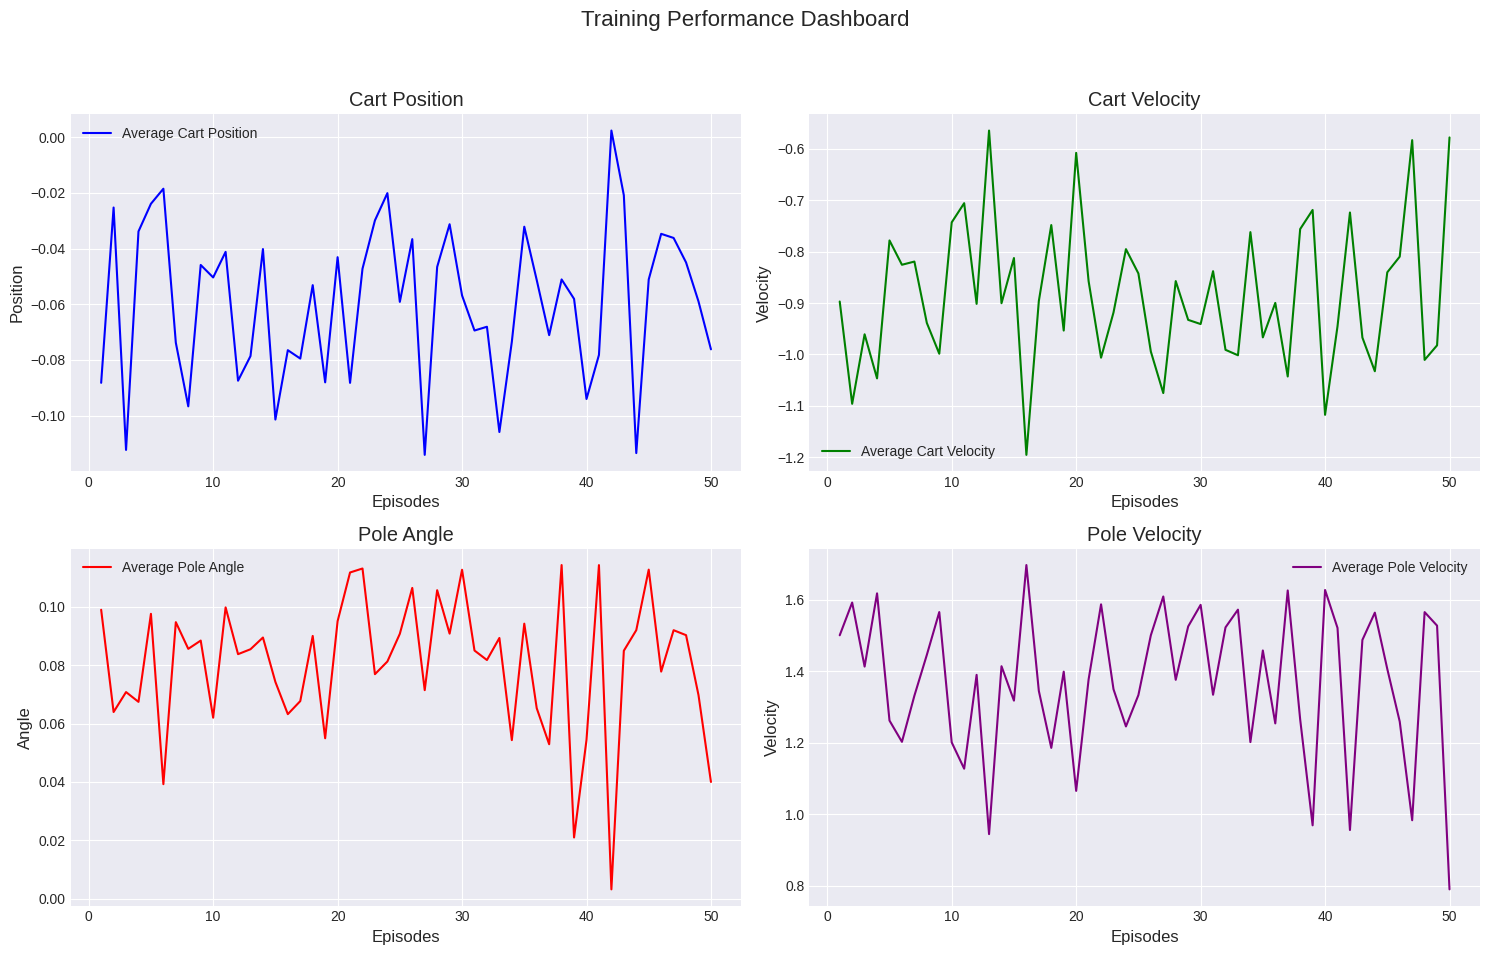

In [348]:
# Get DQN results
model = DQN(n_state, n_action, n_hidden, lr)
train_dqn = q_learning(env, model, episodes, gamma=.9, epsilon=0.3)

In [352]:
# # Expand DQL class with a replay function.
# class DQN_replay(DQN):
#     def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
#         super(DQN, self).__init__()  # Correct usage of super()
#         self.criterion = nn.MSELoss()
#         # Single linear layer
#         self.model = torch.nn.Sequential(
#             torch.nn.Linear(state_dim, action_dim)
#         )
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

#     def replay(self, memory, size, gamma=0.9):
#         """New replay function"""
#         #Try to improve replay speed
#         if len(memory)>=size:
#             batch = random.sample(memory,size)
#             batch_t = list(map(list, zip(*batch))) #Transpose batch list
#             states = batch_t[0]
#             actions = batch_t[1]
#             next_states = batch_t[2]
#             rewards = batch_t[3]
#             is_dones = batch_t[4]

#             states = torch.Tensor(states)
#             actions_tensor = torch.Tensor(actions)
#             next_states = torch.Tensor(next_states)
#             rewards = torch.Tensor(rewards)
#             is_dones_tensor = torch.Tensor(is_dones)

#             is_dones_indices = torch.where(is_dones_tensor==True)[0]

#             all_q_values = self.model(states) # predicted q_values of all states
#             all_q_values_next = self.model(next_states)
#             #Update q values
#             all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
#             all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


#             self.update(states.tolist(), all_q_values.tolist())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


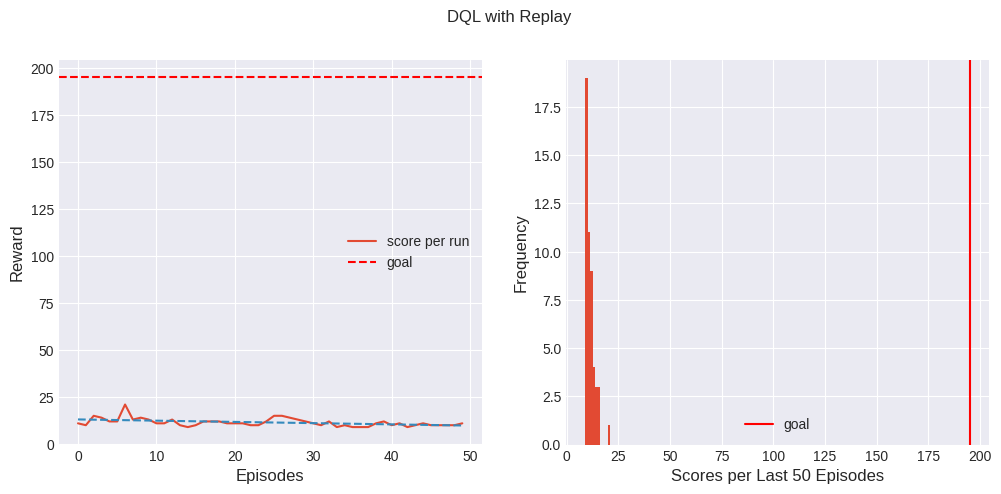

episode: 50, total reward: 11.0
Average replay time: 0.025054364204406737


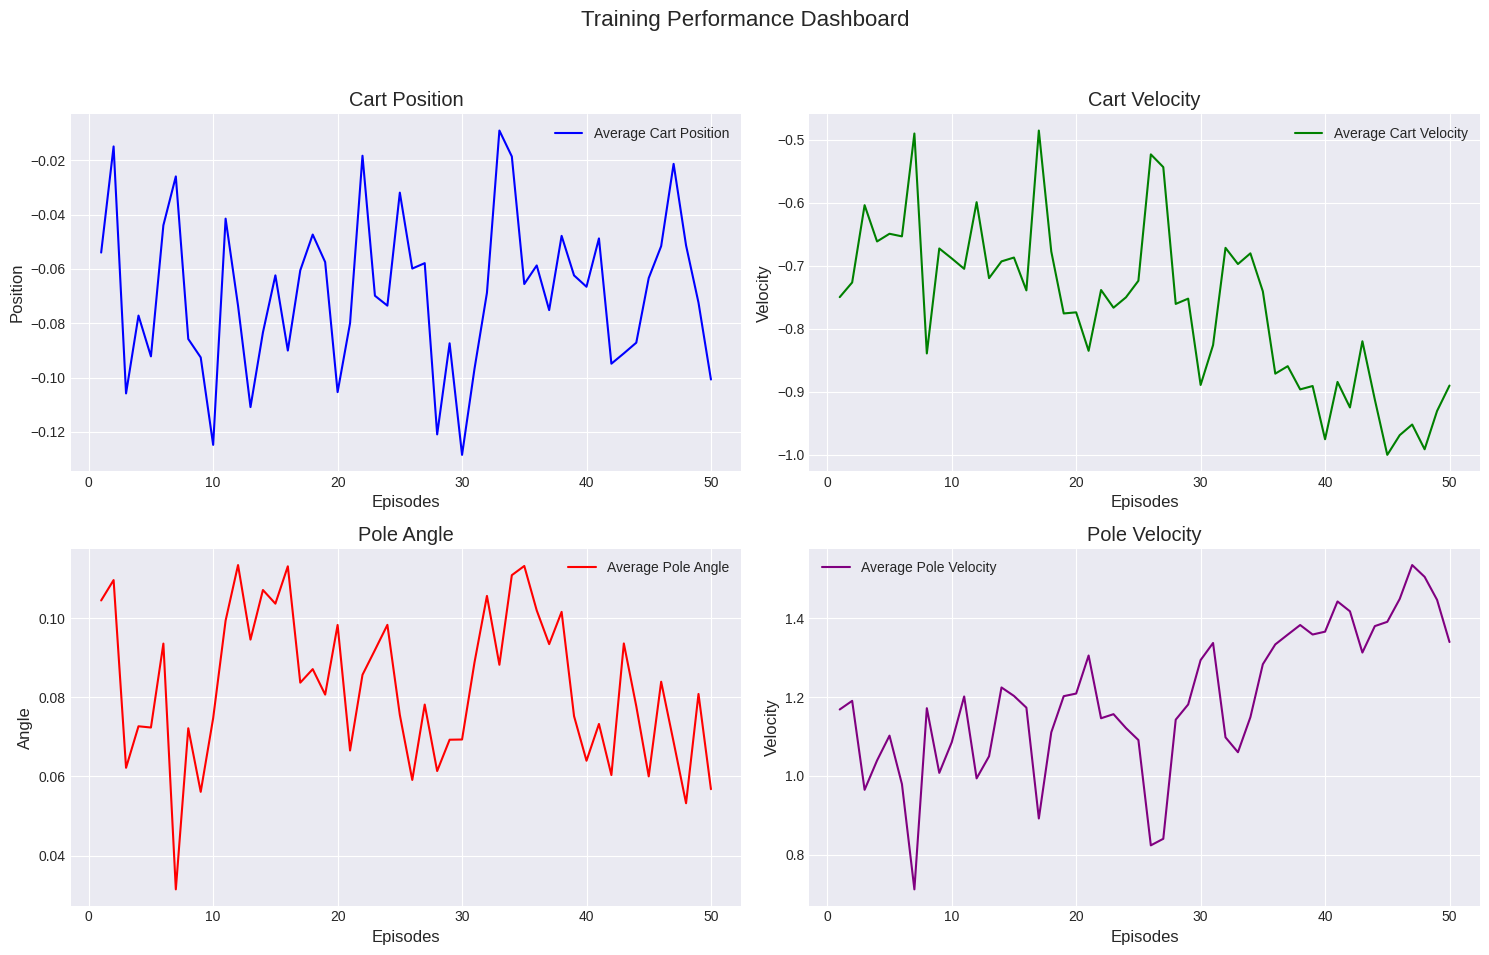

In [353]:
# # Get replay results
# model = DQN_replay(n_state, n_action, n_hidden, lr)
# replay = q_learning(env, model,
#                     episodes, gamma=.9,
#                     epsilon=0.2, replay=True,
#                     title='DQL with Replay')

## References:

(1) Reinforcement Q-Learning from Scratch in Python with OpenAI Gym. (2019). Learndatasci.com. Retrieved 9 December 2019, from https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

(2) Paszke, A., (2019). Reinforcement Learning (DQN) tutorial. Retrieved from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

(3) Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., ... & Wierstra, D. (2015). Continuous control with deep reinforcement learning. arXiv preprint arXiv:1509.02971.

(4) Van Hasselt, H., Guez, A., & Silver, D. (2016, March). Deep reinforcement learning with double q-learning. In Thirtieth AAAI conference on artificial intelligence.

(5) Wang, Z., Schaul, T., Hessel, M., Van Hasselt, H., Lanctot, M., & De Freitas, N. (2015). Dueling network architectures for deep reinforcement learning. arXiv preprint arXiv:1511.06581.

(6) Double DQN Implementation to Solve OpenAI Gym’s CartPole v-0. (2019). Medium. Retrieved 20 December 2019, from https://medium.com/@leosimmons/double-dqn-implementation-to-solve-openai-gyms-cartpole-v-0-df554cd0614d